## **Mount implementation folder in google drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/FYP/Implementation/data
! ls

/content/drive/.shortcut-targets-by-id/1MkC_V0CRXkQ-OsCBxF38m1Sku4w4s3TR/FYP/Implementation/data
encoded-data.csv	preprosessing-dos.csv	  UNSW-NB15_1.csv
NUSW-NB15_features.csv	selected_columns_all.csv  UNSW-NB15_2.csv
OTset.csv		SVR-predict-data.csv	  UNSW-NB15_3.csv
preprocessing.csv	testset.csv		  UNSW-NB15_4.csv


## **Load balanced training datset for DOS attacks**

Data = (x_train, y_train)

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

#get select columns for training
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)
col=list(select_col['Exploits'])


#create training dataset down sampling
df = pd.read_csv('encoded-data.csv', sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']


Exploits_attacks = df[df['Exploits'] == 1]
Normal_Data = df[df['Label'] == 0]
frames = [Exploits_attacks, Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=attack_labels, axis=1)
Y=result[['Exploits']]
X.head()

undersample = RandomUnderSampler(random_state=0)
# fit and apply the transform
X, Y = undersample.fit_resample(X,Y)


x_train,y_train  = shuffle(X[col],Y)


X_train_normalized = preprocessing.normalize(x_train)
X_train_normalized 




array([[1.81562835e-03, 1.94084410e-03, 3.13039371e-04, ...,
        5.52451881e-01, 4.35124725e-08, 9.70422049e-09],
       [0.00000000e+00, 2.54000000e-06, 6.00000000e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25415355e-05, 5.61650897e-05, 9.05888544e-06, ...,
        5.87160719e-02, 2.19225028e-09, 2.89884334e-10],
       ...,
       [0.00000000e+00, 2.85750003e-06, 6.75000007e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.85750003e-06, 6.75000007e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.90484475e-05, 8.45000645e-05, 1.36290427e-05, ...,
        7.65570585e-02, 2.01437251e-09, 3.73435769e-10]])

## **Create Test Set for DOS attacks**

Data = (x_test_DOS_normalized, y_test)

In [17]:
import pandas as pd
import numpy as np
select_col=pd.read_csv("selected_columns_all.csv", sep=',', on_bad_lines='skip', index_col=False)

columns=list(select_col['Exploits'])

test_data =pd.read_csv("testset.csv", sep=',', on_bad_lines='skip', index_col=False)
attack_labels = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] + ['attack_cat','Label']
attack_categories = ['Analysis', 'Backdoors', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'] 

Exploits_attacks  = test_data[test_data['attack_cat'] == 'Exploits']
# print(DoS_attacks.shape)
Normal_Data = test_data[test_data['Label'] == 0]
# print(Normal_Data.shape)

frames = [Exploits_attacks , Normal_Data]
result = pd.concat(frames)
X=result.drop(labels=['attack_cat', 'Label'], axis=1)
Y=result[['Label']]
X.head()

x_test,y_test  = shuffle(X[columns],Y)

x_test = x_test.replace('-','')
x_test = x_test.replace(r'^\s*$', np.nan, regex=True)

#delete raws with missing values
for i in x_test.columns.values.tolist():
  i = x_test.loc[x_test[i].isnull()].index
  x_test = x_test.drop(index=list(i))
  y_test = y_test.drop(index=list(i))

percent_missing = x_test.isnull().sum()
missing_value_df = pd.DataFrame({'column_name': x_test.columns, 'count_missing': percent_missing, 'To be dropped': (percent_missing > 45)})
# print(missing_value_df)

x_test.head()
#encode the data
from sklearn.preprocessing import LabelEncoder

# replace hex with int
# x_test['sport'] = x_test['sport'].astype(str).apply(int, base=16)
# x_test['dsport'] = x_test['dsport'].astype(str).apply(int, base=16)

# #Create an instance of Label-encoder
labelencoder = LabelEncoder() 

# # encode columns consists with strings
x_test['srcip'] = labelencoder.fit_transform(x_test['srcip'])
x_test['dstip'] = labelencoder.fit_transform(x_test['dstip'])
x_test['proto'] = labelencoder.fit_transform(x_test['proto'])
x_test['state'] = labelencoder.fit_transform(x_test['state'])

X_test_normalized = preprocessing.normalize(x_test) 


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


**Random Forrest Regression**

In [18]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


# Number of trees in random forest
n_estimators = [2, 4, 8, 16, 32, 64, 100]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}




 # create regressor object
regressor = GridSearchCV(RandomForestRegressor(random_state=0),param_grid,return_train_score=False)

# fit the regressor with x and y data
regressor.fit(x, y)


df = pd.DataFrame(regressor.cv_results_)
df

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122596,0.002173,0.001676,0.000097,True,2,auto,1,2,2,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.577371,0.579606,0.572789,0.589204,0.577503,0.579295,0.005432,247
1,0.242758,0.006388,0.002371,0.000173,True,2,auto,1,2,4,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.582473,0.572301,0.584165,0.594880,0.578641,0.582492,0.007416,229
2,0.538513,0.069988,0.004225,0.000806,True,2,auto,1,2,8,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.579609,0.584526,0.577878,0.595125,0.571132,0.581654,0.007986,235
3,0.962039,0.025288,0.005854,0.000366,True,2,auto,1,2,16,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.580286,0.581812,0.571371,0.598311,0.575232,0.581402,0.009230,241
4,2.075620,0.244518,0.010981,0.001756,True,2,auto,1,2,32,"{'bootstrap': True, 'max_depth': 2, 'max_featu...",0.584070,0.585285,0.570649,0.599320,0.576737,0.583212,0.009636,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,0.300169,0.003294,0.004233,0.000094,False,4,sqrt,2,5,8,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.798144,0.779502,0.790922,0.790362,0.775869,0.786960,0.008136,133
332,0.592926,0.005883,0.007265,0.000299,False,4,sqrt,2,5,16,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.781875,0.761120,0.775187,0.774608,0.767050,0.771968,0.007174,157
333,1.177829,0.008610,0.012905,0.000441,False,4,sqrt,2,5,32,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.792390,0.783950,0.789731,0.791290,0.789550,0.789382,0.002910,103
334,2.355703,0.015770,0.025468,0.001150,False,4,sqrt,2,5,64,"{'bootstrap': False, 'max_depth': 4, 'max_feat...",0.793390,0.780102,0.786252,0.788312,0.792552,0.788122,0.004801,115


In [19]:
df[['param_bootstrap', 	'param_max_depth', 	'param_max_features', 	'param_min_samples_leaf', 	'param_min_samples_split', 	'param_n_estimators','mean_test_score']]

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score
0,True,2,auto,1,2,2,0.579295
1,True,2,auto,1,2,4,0.582492
2,True,2,auto,1,2,8,0.581654
3,True,2,auto,1,2,16,0.581402
4,True,2,auto,1,2,32,0.583212
...,...,...,...,...,...,...,...
331,False,4,sqrt,2,5,8,0.786960
332,False,4,sqrt,2,5,16,0.771968
333,False,4,sqrt,2,5,32,0.789382
334,False,4,sqrt,2,5,64,0.788122


In [20]:
regressor.best_params_

{'bootstrap': True,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 8}

**Train the model**

In [30]:
from sklearn.ensemble import RandomForestRegressor

#training data
x = np.array(X_train_normalized)
y = np.array(y_train)


 # create regressor object
regressor = RandomForestRegressor(bootstrap=True,max_depth=4,max_features= 'auto',min_samples_leaf=2,min_samples_split=2,n_estimators=8)

# fit the regressor with x and y data
regressor.fit(x, y)

y_pred = regressor.predict(x)


<ipython-input-30-f684aea8fcd5>:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(x, y)


In [31]:
from sklearn.metrics import accuracy_score

for i in range(1,100):
  y_predict_class = [1 if p > i/100 else 0 for p in y_pred]
  print("Accuracy when threshould = ",i/100, round(accuracy_score(y, y_predict_class), 6))

Accuracy when threshould =  0.01 0.93754
Accuracy when threshould =  0.02 0.93754
Accuracy when threshould =  0.03 0.93754
Accuracy when threshould =  0.04 0.93754
Accuracy when threshould =  0.05 0.93754
Accuracy when threshould =  0.06 0.93754
Accuracy when threshould =  0.07 0.93754
Accuracy when threshould =  0.08 0.938547
Accuracy when threshould =  0.09 0.938566
Accuracy when threshould =  0.1 0.938585
Accuracy when threshould =  0.11 0.938585
Accuracy when threshould =  0.12 0.938585
Accuracy when threshould =  0.13 0.938286
Accuracy when threshould =  0.14 0.938286
Accuracy when threshould =  0.15 0.938286
Accuracy when threshould =  0.16 0.938286
Accuracy when threshould =  0.17 0.938286
Accuracy when threshould =  0.18 0.939182
Accuracy when threshould =  0.19 0.939555
Accuracy when threshould =  0.2 0.939555
Accuracy when threshould =  0.21 0.939555
Accuracy when threshould =  0.22 0.939555
Accuracy when threshould =  0.23 0.939555
Accuracy when threshould =  0.24 0.939555
A

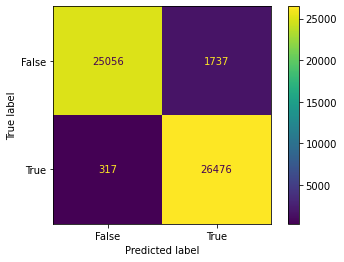

In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

threshould =0.5

y_predict_class = [1 if p > threshould else 0 for p in y_pred]
confusion_matrix = metrics.confusion_matrix(y, y_predict_class)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 


**Test Set Accuracy**

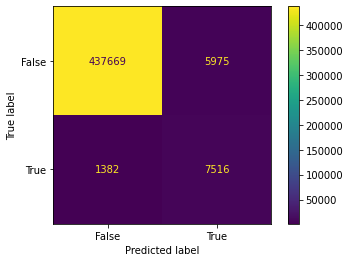

Accuracy when threshould =  0.8 0.983743


In [36]:
x_test_array = np.array(X_test_normalized)
y_test_array = np.array(y_test)
y_pred_test_set = regressor.predict(x_test_array)


threshould =0.8


y_predict_test_set_class = [1 if p > threshould else 0 for p in y_pred_test_set]
confusion_matrix = metrics.confusion_matrix(y_test_array, y_predict_test_set_class)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show() 

print("Accuracy when threshould = ",threshould, round(accuracy_score(y_test_array, y_predict_test_set_class), 6))